In [1]:
import numpy as np 
import torch 
from tqdm import tqdm 
import pickle 
import pandas as pd
from typing import List, Dict, Any, Tuple, Union, Optional, Callable
import requests 
import time
from collections import defaultdict 

import datasets
from datasets import load_dataset
from dataclasses import dataclass
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys
sys.path.append('../') 

from white_box.model_wrapper import ModelWrapper
from white_box.utils import gen_pile_data 
from white_box.dataset import clean_data 
from white_box.chat_model_utils import load_model_and_tokenizer, get_template, MODEL_CONFIGS

from white_box.dataset import PromptDist, ActDataset, create_prompt_dist_from_metadata_path, ProbeDataset
from white_box.probes import LRProbe
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, roc_auc_score
import plotly.express as px

%load_ext autoreload
%autoreload 2

In [2]:
model_name = 'llama2_7b'
data_path = f"../data/{model_name}/"

In [3]:
# model_config = MODEL_CONFIGS[model_name]
# model, tokenizer = load_model_and_tokenizer(**model_config)
# template = get_template(model_name, chat_template=model_config.get('chat_template', None))['prompt']

# mw = ModelWrapper(model, tokenizer, template = template)

## probing harmful vs harmless input

In [13]:
# from white_box.jb_experiments import plot_acc_auc
# file_spec = "jb_"
# harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
# harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
# print(len(harmless.idxs), len(harmful.idxs))
# dataset = ActDataset([harmful], [harmless])
# dataset.instantiate()
# probe_dataset = ProbeDataset(dataset)

In [ ]:
from white_box.jb_experiments import plot_acc_auc
file_spec = "generated_no_rephrase_test_"
harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
probe_dataset = ProbeDataset(dataset)

test_generated_metadata = pd.read_csv(data_path + f'/{file_spec}metadata.csv')

59 59


In [17]:
from white_box.jb_experiments import plot_acc_auc
file_spec = "harmbench_alpaca_"
harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
test_probe_dataset = ProbeDataset(dataset)

1200 1200


In [5]:
from white_box.jb_experiments import plot_acc_auc
file_spec = "gpt_generated_"
harmful = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1)")
harmless =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0)")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
gpt_probe_dataset = ProbeDataset(dataset)

500 500


In [6]:
from white_box.jb_experiments import plot_acc_auc
file_spec = "jb_"
harmless = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['jb_name'] == 'harmless')")
harmful =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['jb_name'] == 'DirectRequest')")
print(len(harmless.idxs), len(harmful.idxs))
dataset = ActDataset([harmful], [harmless])
dataset.instantiate()
jb_probe_dataset = ProbeDataset(dataset)

100 103


In [7]:
file_spec = "jb_"
jb_metadata = pd.read_csv(f"{data_path}/{file_spec}metadata.csv", sep = "t")
jbs =  create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 1) & (metadata['jb_name'] != 'DirectRequest')")
failed_jbs = create_prompt_dist_from_metadata_path(data_path + f'/{file_spec}metadata.csv', col_filter = "(metadata['label'] == 0) & (metadata['jb_name'] != 'DirectRequest') & (metadata['jb_name'] != 'harmless')")
print(len(jbs.idxs), len(failed_jbs.idxs))
dataset = ActDataset([jbs], [failed_jbs])
dataset.instantiate()
jb_labeled_by_success_probe_dataset = ProbeDataset(dataset)

427 430


In [8]:
# from sklearn.decomposition import PCA 
# from sklearn.preprocessing import StandardScaler
# tok_idx = 0
# layer = 16

# X = probe_dataset.act_dataset.X[:, layer, tok_idx]
# pca = PCA(n_components=2)
# pca.fit(X.numpy())

# normalize = False

# if normalize:
#     scaler = StandardScaler()
#     X_normalized = scaler.fit_transform(X)
#     pca_result = pca.fit_transform(X_normalized)
# else:
#     pca_result = pca.fit_transform(X)

# pc_x = 0
# pc_y = 1
# pca_df = pd.DataFrame.from_dict({"x" : pca_result[:, pc_x], 
#                         "y" : pca_result[:, pc_y], 
#                         "label": probe_dataset.act_dataset.y,
#                         "prompt": generated_metadata['prompt'].values, 
#                         })
# fig = px.scatter(pca_df, x="x", y="y", hover_data = ["prompt"],
#                  color="label", 
#                  )
# fig.update_layout(
#     title=f'PCA of Layer {layer} Activations, TOKEN_IDX {tok_idx}',
#     xaxis_title=f'PC{pc_x}',
#     yaxis_title=f'PC{pc_y}',
#     showlegend=True
# )

# fig.show()

In [24]:
accs, aucs, hb_dolly_probes = [], [], []
for layer in tqdm(range(32)):
    acc, auc, probe = test_probe_dataset.train_sk_probe(layer, tok_idxs = list(range(5)), test_size = 0.2, C = 1e-2, 
                                                  max_iter = 2000,
                                                   random_state = None, use_train_test_split=True)

    # acc, auc, probe = probe_dataset.train_mm_probe(layer, tok_idxs=list(range(5)), test_size=None, device='cpu')

    accs.append(acc)
    aucs.append(auc)
    hb_dolly_probes.append(probe)

100%|██████████| 32/32 [01:42<00:00,  3.20s/it]


In [25]:
plot_acc_auc(accs, aucs, title = "Generated Train, probes trained on last 5 token positions")

In [20]:
metrics = defaultdict(list)

for layer in range(32):
    pred_probas = hb_dolly_probes[layer].predict_proba(test_probe_dataset.act_dataset.X[:, layer])
    probas_mean = pred_probas.mean(dim=-1).detach().cpu().numpy()
    labels = test_probe_dataset.act_dataset.y.detach().cpu().numpy()

    metrics['acc'].append(accuracy_score(labels, probas_mean > 0.5))
    metrics['auc'].append(roc_auc_score(labels, probas_mean))
    metrics['TPR'].append(((probas_mean > 0.5) & (labels == 1)).sum() / (labels == 1).sum())
    metrics['TNR'].append(((probas_mean < 0.5) & (labels == 0)).sum() / (labels == 0).sum())
    metrics['FPR'].append(((probas_mean > 0.5) & (labels == 0)).sum() / (labels == 0).sum())
    metrics['FNR'].append(((probas_mean < 0.5) & (labels == 1)).sum() / (labels == 1).sum())

In [21]:
import plotly.graph_objects as go

fig = go.Figure()
x = list(range(32))
fig.add_trace(go.Scatter(x=x, y=metrics['acc'], mode='lines', name='Accuracy'))
fig.add_trace(go.Scatter(x=x, y=metrics['auc'], mode='lines', name='AUC'))
fig.add_trace(go.Scatter(x=x, y=metrics['TPR'], mode='lines', name='TPR'))
fig.add_trace(go.Scatter(x=x, y=metrics['TNR'], mode='lines', name='TNR'))
fig.add_trace(go.Scatter(x=x, y=metrics['FPR'], mode='lines', name='FPR'))
fig.add_trace(go.Scatter(x=x, y=metrics['FNR'], mode='lines', name='FNR'))
fig.update_layout(
    title=f"Test on HB-Alpaca test",
    xaxis_title="Layers",
    yaxis_title="Value",
)
fig.show()


/tmp/ipykernel_60539/1511876192.py:14: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



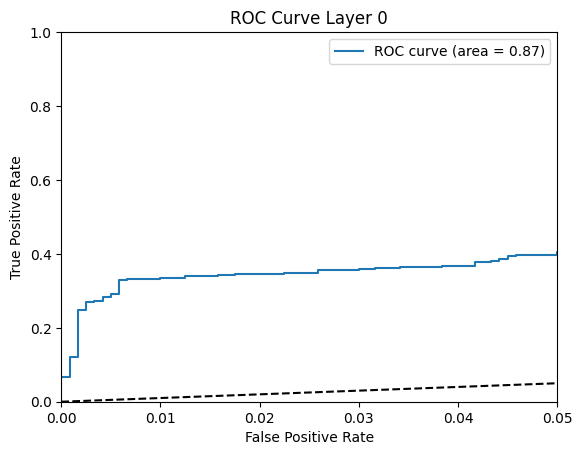

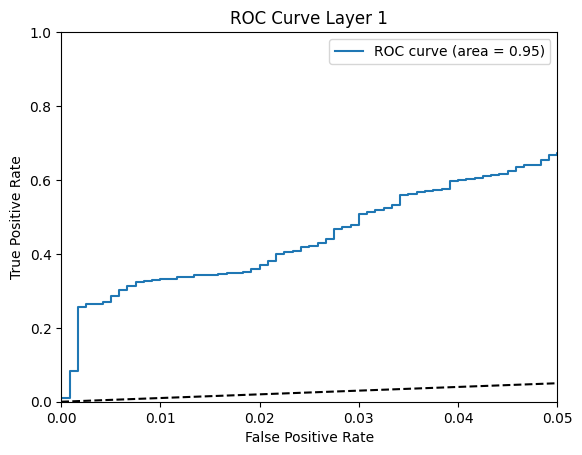

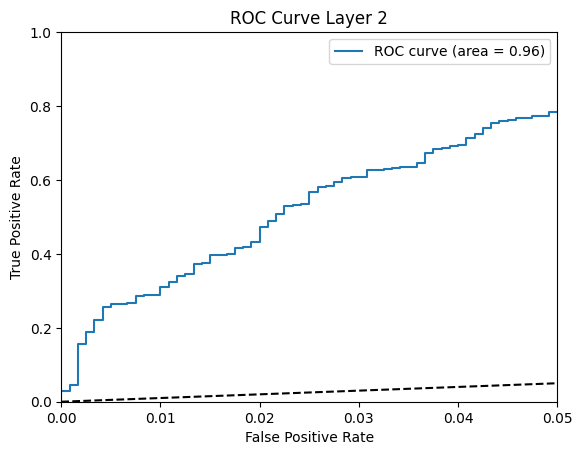

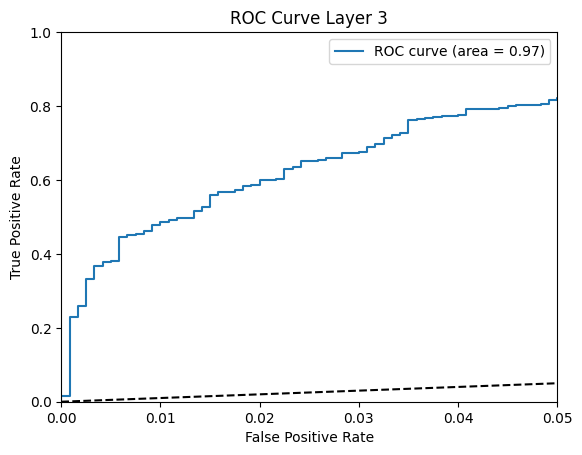

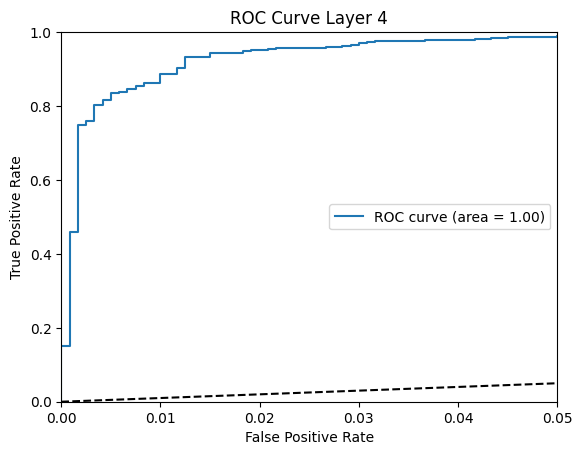

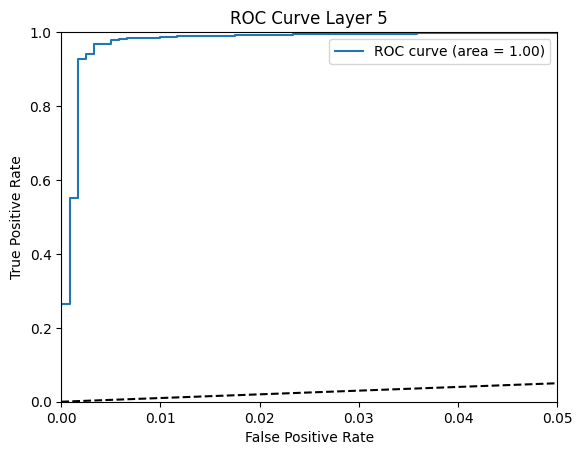

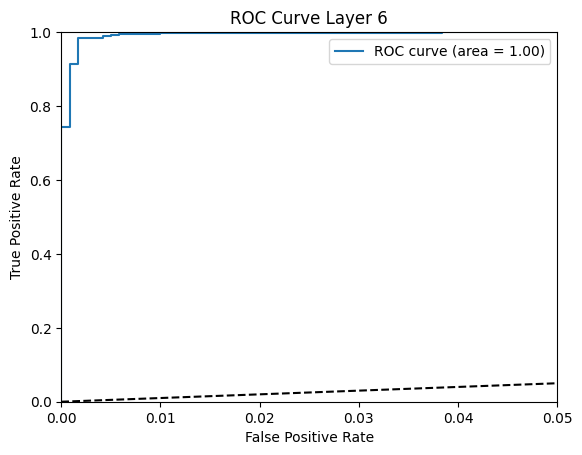

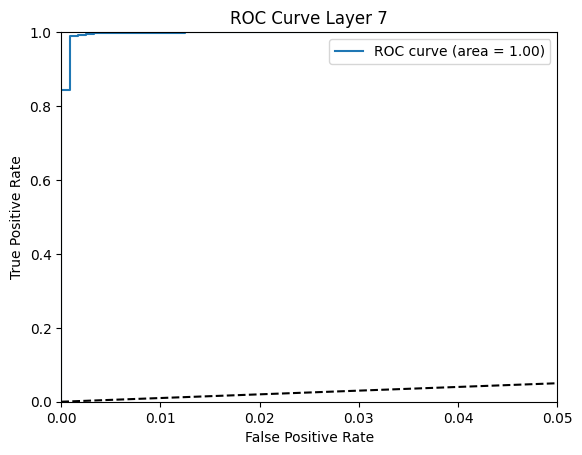

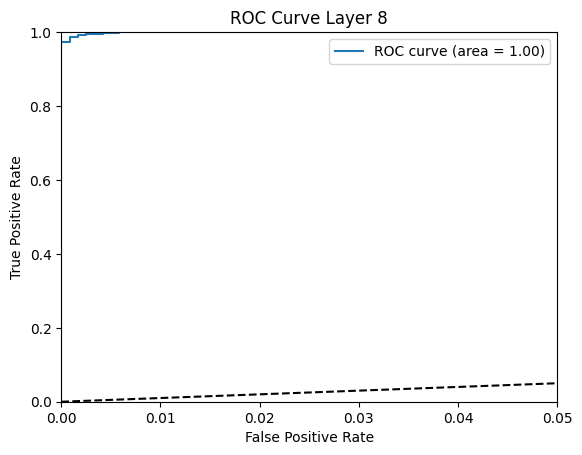

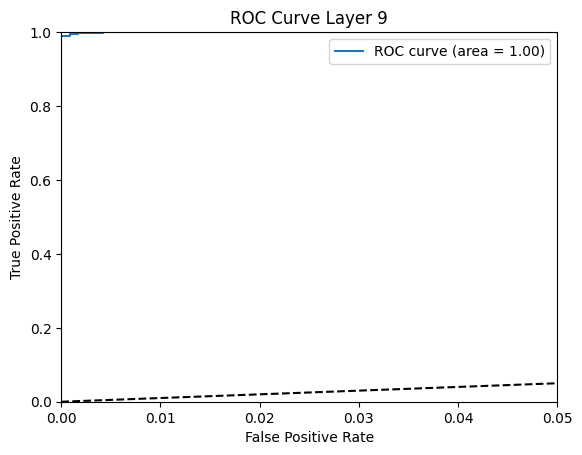

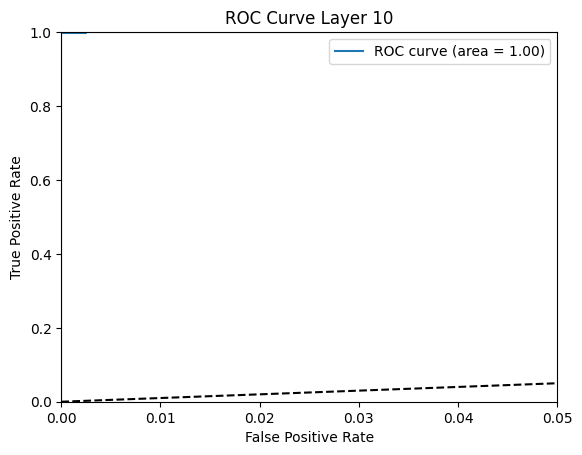

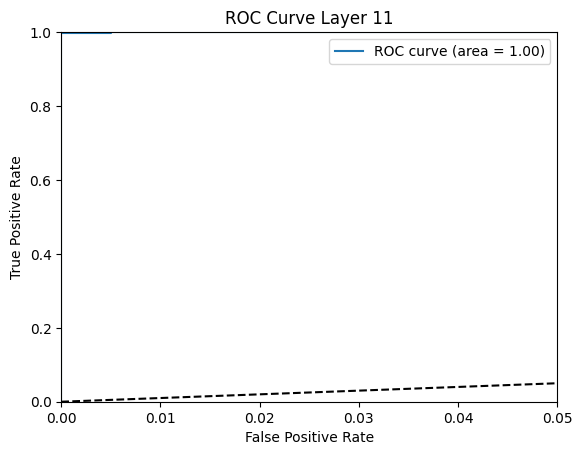

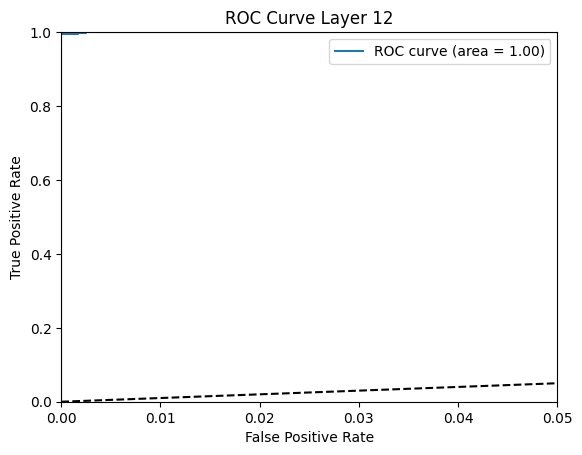

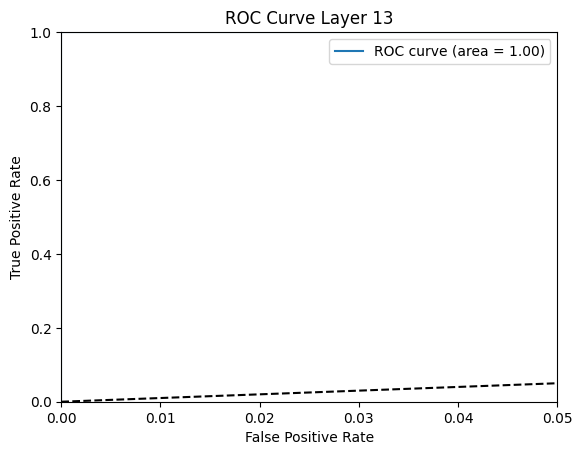

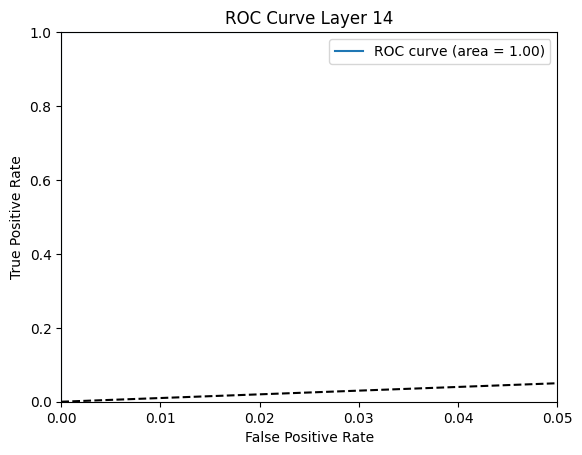

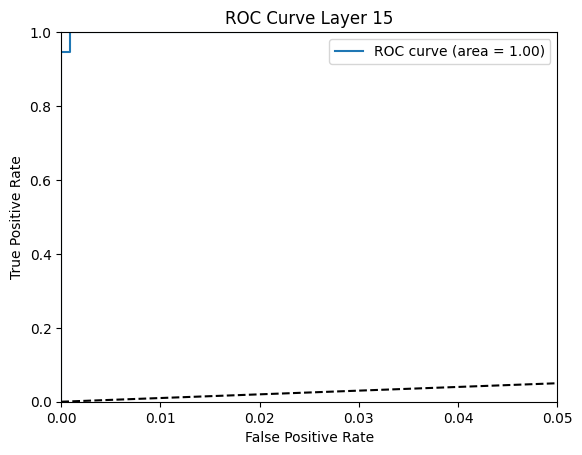

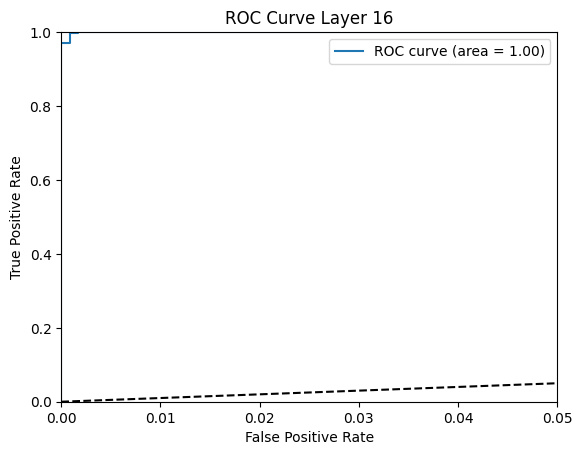

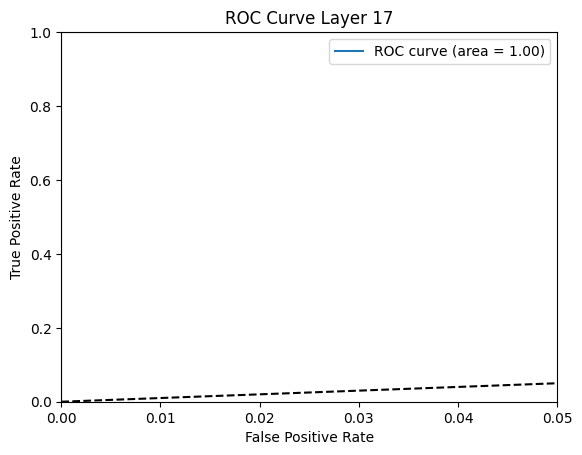

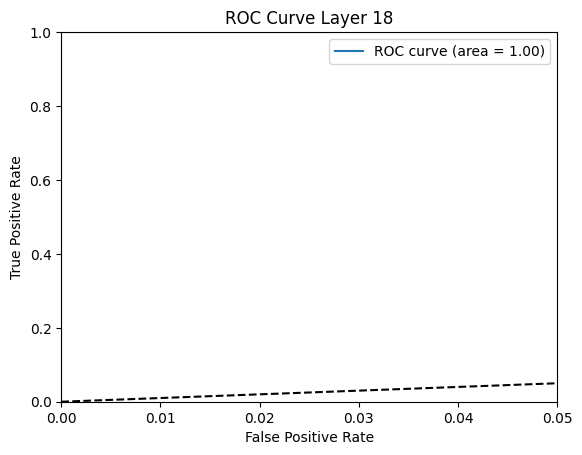

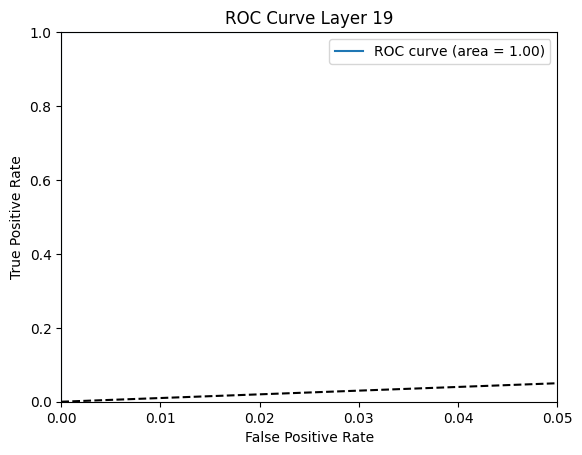

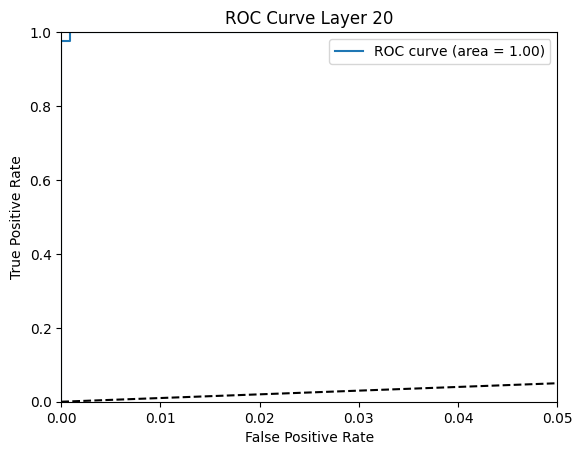

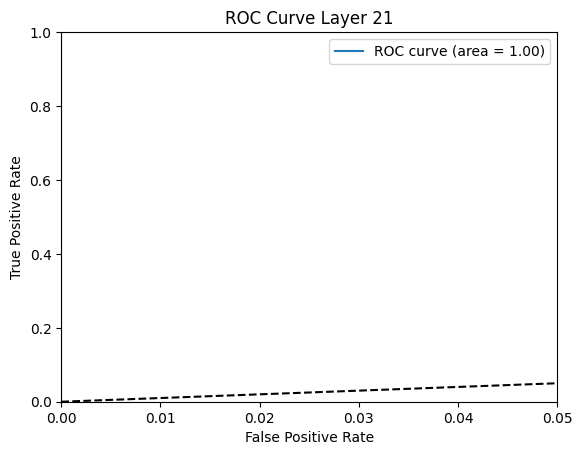

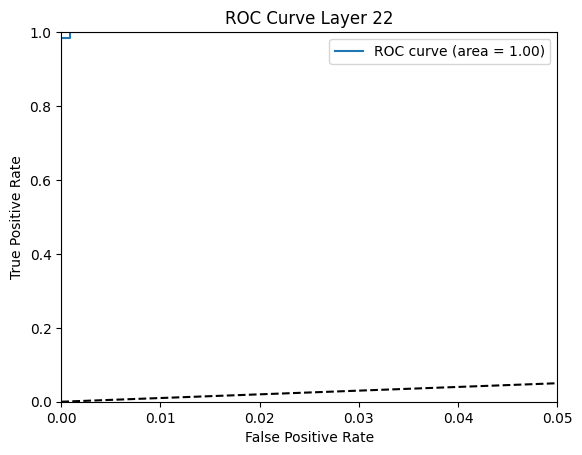

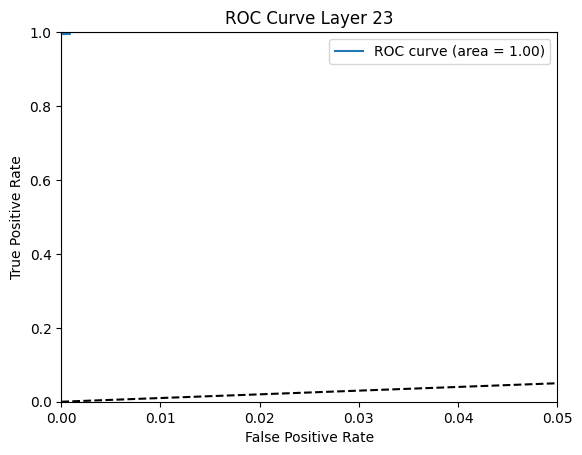

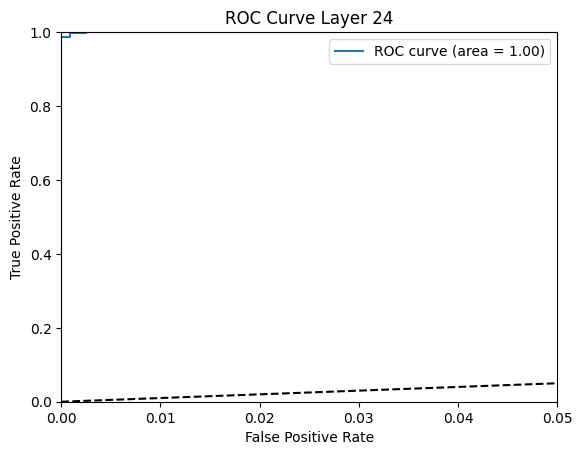

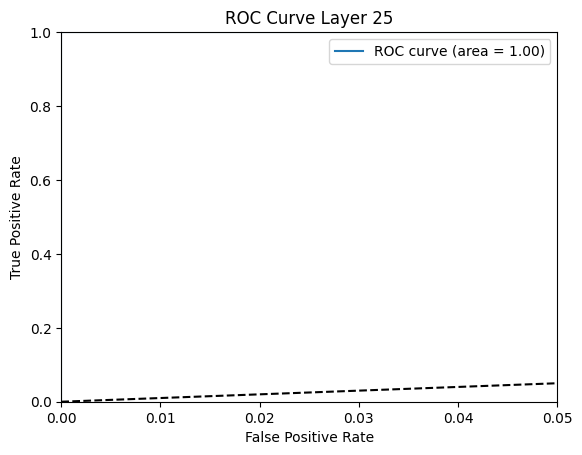

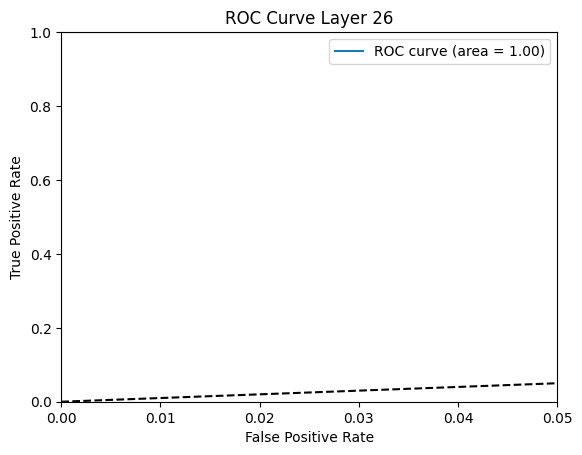

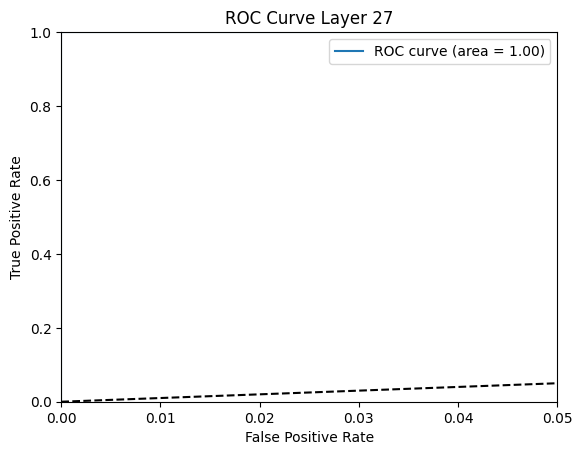

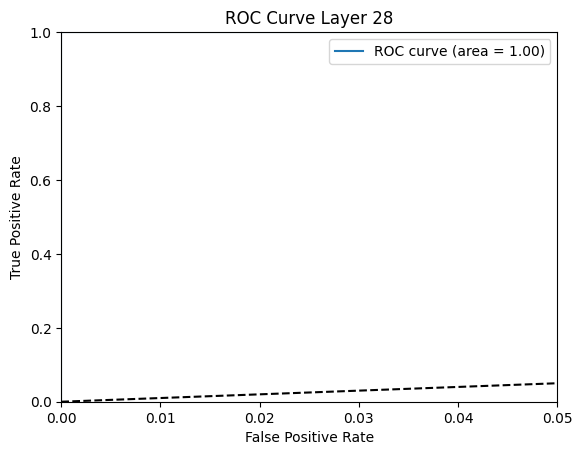

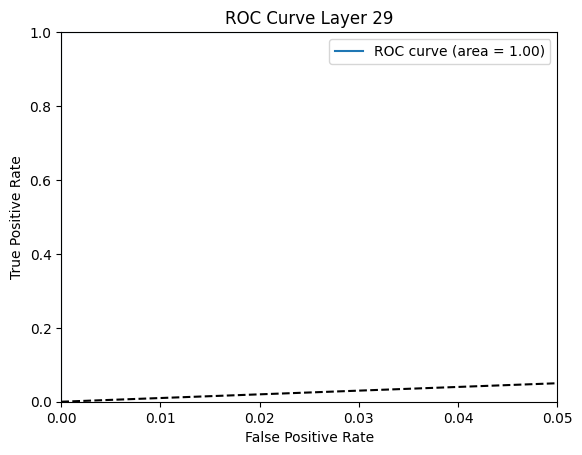

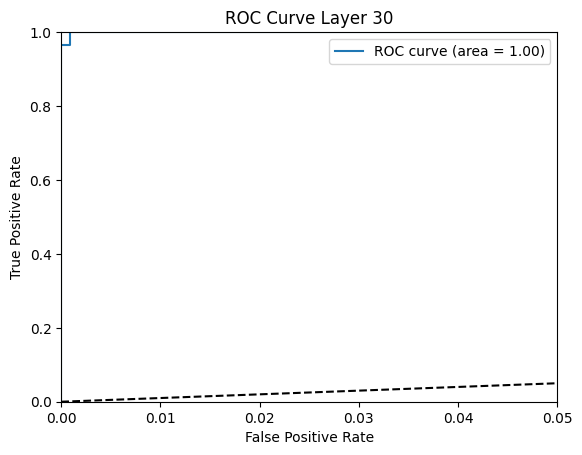

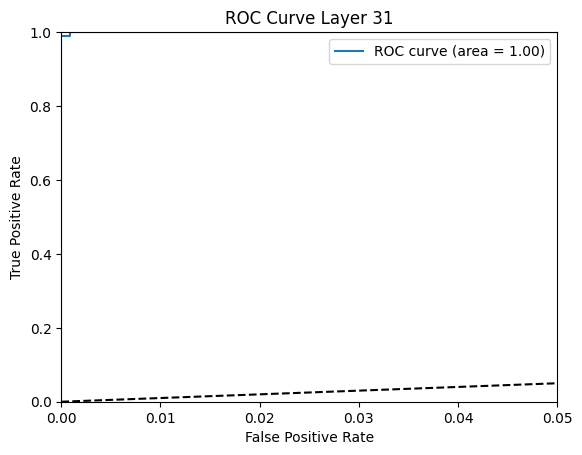

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

for layer in range(32):
    pred_probas = hb_dolly_probes[layer].predict_proba(test_probe_dataset.act_dataset.X[:, layer])
    probas_mean = pred_probas.mean(dim=-1).detach().cpu().numpy()
    labels = test_probe_dataset.act_dataset.y.detach().cpu().numpy()

    # plot roc curve
    fpr, tpr, _ = roc_curve(labels, probas_mean)
    roc_auc = auc(fpr, tpr)
    
    # zoom in on 0 to 5% FPR range
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 0.05])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve Layer {layer}')
    ax.legend()
    


In [17]:
metrics = defaultdict(list)

for layer in range(32):
    pred_probas = hb_dolly_probes[layer].predict_proba(jb_probe_dataset.act_dataset.X[:, layer])
    probas_mean = pred_probas.mean(dim=-1).detach().cpu().numpy()
    labels = jb_probe_dataset.act_dataset.y.detach().cpu().numpy()

    metrics['acc'].append(accuracy_score(labels, probas_mean > 0.5))
    metrics['auc'].append(roc_auc_score(labels, probas_mean))
    metrics['TPR'].append(((probas_mean > 0.5) & (labels == 1)).sum() / (labels == 1).sum())
    metrics['TNR'].append(((probas_mean < 0.5) & (labels == 0)).sum() / (labels == 0).sum())

In [18]:
import plotly.graph_objects as go

fig = go.Figure()
x = list(range(32))
fig.add_trace(go.Scatter(x=x, y=metrics['acc'], mode='lines', name='Accuracy'))
fig.add_trace(go.Scatter(x=x, y=metrics['auc'], mode='lines', name='AUC'))
fig.add_trace(go.Scatter(x=x, y=metrics['TPR'], mode='lines', name='TPR'))
fig.add_trace(go.Scatter(x=x, y=metrics['TNR'], mode='lines', name='TNR'))
fig.update_layout(
    title=f"HB-alpaca probe, tested on jb dataset (100 positives from harmbench, 100 negatives from GPT4)",
    xaxis_title="Layers",
    yaxis_title="Value",
)
fig.show()


In [19]:
metrics = defaultdict(list)

for layer in range(32):
    pred_probas = hb_dolly_probes[layer].predict_proba(jb_labeled_by_success_probe_dataset.act_dataset.X[:, layer])
    probas_mean = pred_probas.mean(dim=-1).detach().cpu().numpy()
    labels = jb_labeled_by_success_probe_dataset.act_dataset.y.detach().cpu().numpy()

    metrics['acc'].append(accuracy_score(labels, probas_mean > 0.5))
    metrics['auc'].append(roc_auc_score(labels, probas_mean))
    metrics['TPR'].append(((probas_mean > 0.5) & (labels == 1)).sum() / (labels == 1).sum())
    metrics['TNR'].append(((probas_mean < 0.5) & (labels == 0)).sum() / (labels == 0).sum())

In [20]:
import plotly.graph_objects as go

fig = go.Figure()
x = list(range(32))
fig.add_trace(go.Scatter(x=x, y=metrics['acc'], mode='lines', name='Accuracy'))
fig.add_trace(go.Scatter(x=x, y=metrics['auc'], mode='lines', name='AUC'))
fig.add_trace(go.Scatter(x=x, y=metrics['TPR'], mode='lines', name='TPR'))
fig.add_trace(go.Scatter(x=x, y=metrics['TNR'], mode='lines', name='TNR'))
fig.update_layout(
    title=f"HB-alpaca probe, tested on jb dataset (800 total, labeled by success)",
    xaxis_title="Layers",
    yaxis_title="Value",
)
fig.show()


## gcg

In [53]:
def parse_log_file(file_path):
    # Initialize storage for the runs
    runs = []
    current_run = {
        'monitor_loss': [],
        'gcg_loss': [],
        'early_stop' : 0,
    }
    last_step = -1
    all_lines = []
    with open(file_path, 'r') as file:
        for line in file:
            all_lines.append(line)
    
    for i, line in enumerate(all_lines):
        # Check if line contains loss information
        if "monitor_loss" in line and "gcg_loss" in line:
            step_line = all_lines[i + 1]
            if 'Early Stop' in step_line:
                current_run['early_stop'] = 1
            try:
                step = int(step_line.split('|')[0].strip().split(' ')[1])
                # print(step_line)
            except:
                try:
                    step_line = all_lines[i + 2]
                    step = int(step_line.split('|')[0].strip().split(' ')[1])
                except:
                    step =   last_step + 1

            # Reset for a new run if the step number goes back to the start
            if step <= last_step:
                runs.append(current_run)
                current_run = {
                    'monitor_loss': [],
                    'gcg_loss': [],
                    'early_stop' : 0
                }
            
            # Update the last step seen
            last_step = step
            
            # Extract losses
            try:
                monitor_loss = float(line.split('monitor_loss :')[1].split('|')[0].strip())
            except:
                continue 
            
            gcg_loss = float(line.split('gcg_loss :')[1].split('|')[0].strip())

            # Append losses to the current run
            current_run['monitor_loss'].append(monitor_loss)
            current_run['gcg_loss'].append(gcg_loss)

    # Add the last run if it hasn't been added
    if current_run['monitor_loss'] and current_run['gcg_loss']:
        runs.append(current_run)

    return runs[1:]

In [55]:
run1 = parse_log_file("../data/llama2_7b/pure_gcg_run.out")
run2 = parse_log_file("../data/llama2_7b/pure_gcg_20exclam_posidx18.out")
all_runs_data = run1 + run2

In [58]:
sum([all_runs_data[i]['early_stop'] for i in range(len(all_runs_data))]) / len(all_runs_data)

0.54

In [4]:
import json
all_runs_data = []

with open(f"{data_path}gcg_run_lyr24.json", "r") as file:
    for line in file:
        try:
            json_data = json.loads(line)
            all_runs_data.append(json_data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue

In [12]:
all_runs_data[0].keys()

dict_keys(['losses', 'monitor_losses', 'gcg_losses', 'optim_strings', 'early_stopping'])

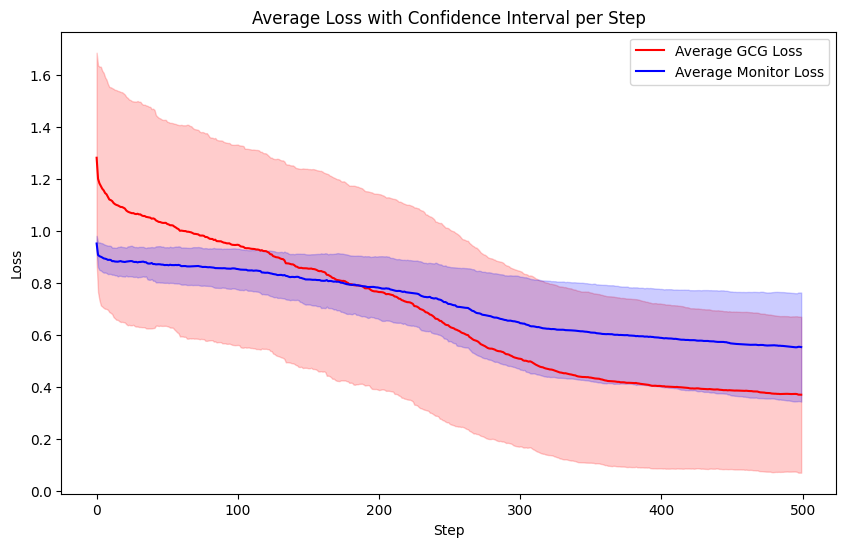

In [21]:
import matplotlib.pyplot as plt

num_runs = 50
steps_per_run = 500

# Compute mean and standard deviation across runs
monitor_loss_means = np.mean([run['monitor_losses'][:steps_per_run] for run in all_runs_data], axis=0)
monitor_loss_stds = np.std([run['monitor_losses'][:steps_per_run] for run in all_runs_data], axis=0)

gcg_loss_means = np.mean([run['gcg_losses'][:steps_per_run] for run in all_runs_data], axis=0)
gcg_loss_stds = np.std([run['gcg_losses'][:steps_per_run]for run in all_runs_data], axis=0)

early_stop_means = np.mean([run['early_stopping'][:steps_per_run] for run in all_runs_data], axis=0)
early_stop_stds = np.std([run['early_stopping'][:steps_per_run]for run in all_runs_data], axis=0)

loss_means = np.mean([run['losses'][:steps_per_run] for run in all_runs_data], axis=0)
loss_std = np.std([run['losses'][:steps_per_run]for run in all_runs_data], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

# GCG loss plot
ax.plot(gcg_loss_means, label='Average GCG Loss', color='red')
ax.fill_between(range(steps_per_run), 
                gcg_loss_means - gcg_loss_stds, 
                gcg_loss_means + gcg_loss_stds, 
                color='red', alpha=0.2)

#Monitor loss plot
ax.plot(monitor_loss_means, label='Average Monitor Loss', color='blue')
ax.fill_between(range(steps_per_run), 
                monitor_loss_means - monitor_loss_stds, 
                monitor_loss_means + monitor_loss_stds, 
                color='blue', alpha=0.2)

# Adding labels and title
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Average Loss with Confidence Interval per Step')
ax.legend()

plt.show()


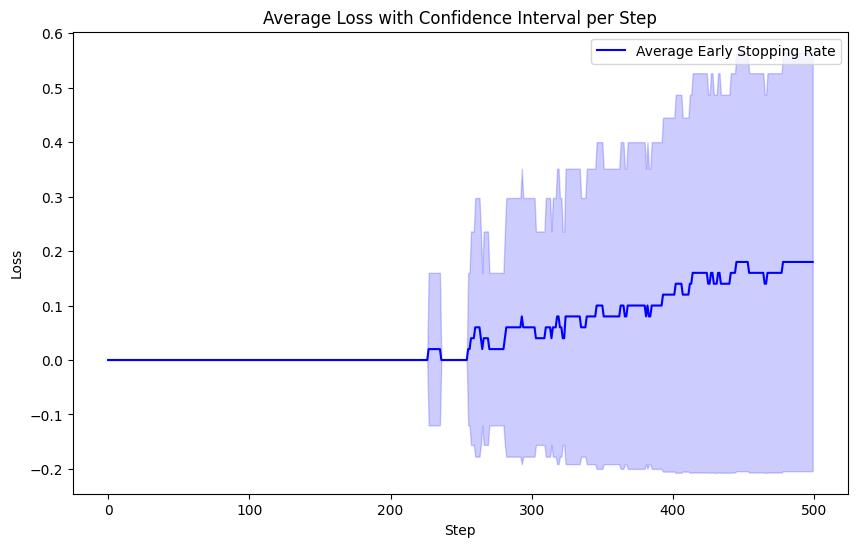

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(early_stop_means, label='Average Early Stopping Rate', color='blue')
ax.fill_between(range(steps_per_run), 
                early_stop_means - early_stop_stds, 
                early_stop_means + early_stop_stds, 
                color='blue', alpha=0.2)

# Adding labels and title
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Average Loss with Confidence Interval per Step')
ax.legend()

plt.show()

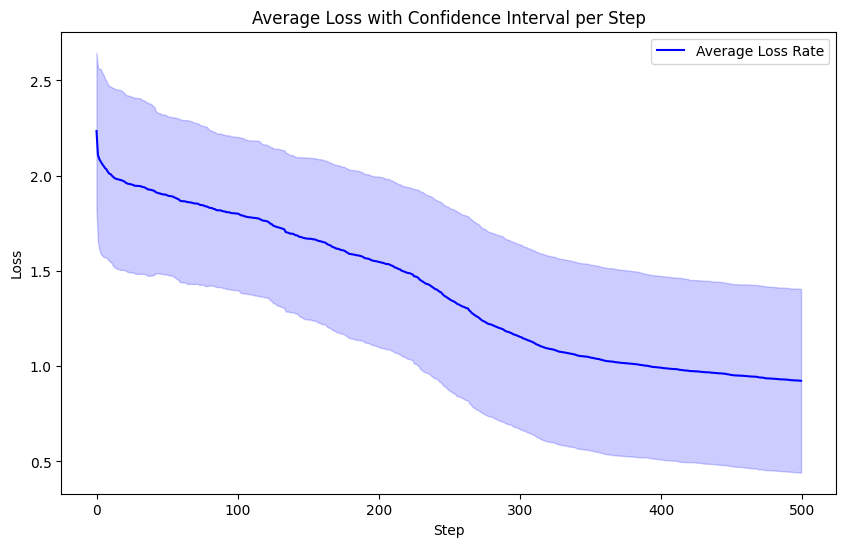

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(loss_means, label='Average Loss Rate', color='blue')
ax.fill_between(range(steps_per_run), 
                loss_means - loss_std, 
                loss_means + loss_std, 
                color='blue', alpha=0.2)

# Adding labels and title
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Average Loss with Confidence Interval per Step')
ax.legend()

plt.show()

In [10]:
sum([all_runs_data[i]['early_stopping'][-1] for i in range(len(all_runs_data))]) / len(all_runs_data)

0.18

In [13]:
sum([ (all_runs_data[i]['monitor_losses'][-1] < 0.5) for i in range(len(all_runs_data))]) / len(all_runs_data)

0.4

In [19]:
sum([ (all_runs_data[i]['gcg_losses'][-1] < 0.3) for i in range(len(all_runs_data))]) / len(all_runs_data)

0.5